# FinMark Corporation — Exploratory Data Analysis, Data Visualization & Statistical Insights

**Author:** MO-IT162 S3103 Group 2

**Lead Developer:** Abegail Imee Enriquez

**Members:** Francisco Cabangon, Dianna Cathlene De Leon, Sean Saniel Solis, Alvin Tubtub

**Date:** October 2025  

**Dataset:** FINAL_merged_cleaned_dataset.csv

---

## Executive Summary

This comprehensive exploratory data analysis examines customer behavior, spending patterns, and engagement metrics from the FinMarks dataset. Through rigorous statistical testing and visual analysis, we uncover key insights into demographic distributions, revenue trends, and categorical associations that inform strategic business decisions.

**Key Analytical Components:**
- Demographic profiling and segmentation analysis
- Outlier detection using Interquartile Range (IQR) methodology
- Statistical hypothesis testing (ANOVA, Chi-Square, Pearson Correlation)
- Time-series revenue analysis with stationarity testing
- Customer engagement patterns across platforms and interaction types

**Methodology:**
All visualizations employ a consistent pink gradient color palette for professional presentation. Unknown or missing categorical values have been systematically excluded to ensure data quality and interpretability. Statistical tests are conducted at α = 0.05 significance level.

---

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
sns.set(style='whitegrid', font_scale=1.05)

# Output dir
OUT = Path("eda_outputs")
OUT.mkdir(exist_ok=True)

# Load data
DATA_CANDIDATES = [Path('FINAL_merged_cleaned_dataset.csv'), Path('data/FINAL_merged_cleaned_dataset.csv')]
path = next((p for p in DATA_CANDIDATES if p.exists()), None)
if path is None:
    raise FileNotFoundError('Place FINAL_merged_cleaned_dataset.csv next to this notebook or under ./data')

df = pd.read_csv(path)
df.columns = df.columns.str.strip().str.lower()
for dcol in ['signupdate', 'transactiondate', 'interactiondate']:
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
for c in ['age', 'total_spent', 'avg_spent', 'num_transactions', 'max_transaction', 'min_transaction', 'amount']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print('Loaded:', path)
print('Shape:', df.shape)
df.head(2)

Loaded: FINAL_merged_cleaned_dataset.csv
Shape: (3030, 23)


,customer_id,age,gender,location,incomelevel,signupdate,total_spent,avg_spent,num_transactions,max_transaction,...,interactiondate,transactionid,interactionid,productcategory,paymentmethod,platform,interactiontype,sentiment,ishighspender,amount
0,9207fa75-5758-48d1-94ad-19c041e0520f,51.0,Female,Jensenberg,Low,2022-11-17,1157.495,578.7475,2,660.87,...,2024-01-11,504a03b0-294d-4e3c-9bf7-46935ba6c47a,0626cfe9-8e7f-4b19-ba9b-21330cd007c8,Clothing,Debit Card,Instagram,Comment,Negative,1.0,496.625
1,9207fa75-5758-48d1-94ad-19c041e0520f,51.0,Female,Jensenberg,Low,2022-11-17,1157.495,578.7475,2,660.87,...,2023-08-25,504a03b0-294d-4e3c-9bf7-46935ba6c47a,20320eb9-5f38-41f5-b855-e0a0880d8c46,Clothing,Debit Card,Facebook,Share,Positive,1.0,496.625


In [300]:
# Pink gradient palette
pink_grad_reversed = ['#ba2d65', '#d93a7f', '#ec4f8e', '#f06d9f', '#f48ab0', '#f7a8c2', '#fac5d3', '#fde2e4']

# Gender-specific colors: Pink for Female, Light Blue for Male
gender_colors = {'Female': '#ec4f8e', 'Male': '#89CFF0'}

def use_palette(n=8):
    """Returns n colors from the gradient, evenly distributed"""
    if n <= 1:
        return [pink_grad_reversed[0]]
    # Distribute colors evenly across the gradient
    indices = [int(i * (len(pink_grad_reversed) - 1) / (n - 1)) for i in range(n)]
    return [pink_grad_reversed[i] for i in indices]

def print_note(title, lines):
    print(title)
    lines = [lines] if isinstance(lines, str) else lines
    for ln in lines:
        print(ln)

def iqr_bounds(s):
    s = s.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

def safe_pearson(x, y):
    ok = x.notna() & y.notna()
    return stats.pearsonr(x[ok], y[ok]) if ok.sum() > 2 else (np.nan, np.nan)

def cramers_v(x, y):
    import scipy.stats as ss
    tbl = pd.crosstab(x, y)
    if tbl.size == 0:
        return 0.0
    chi2 = ss.chi2_contingency(tbl)[0]
    n = tbl.sum().sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = tbl.shape
    phi2c = max(0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0
    rc = r - ((r-1)**2)/(n-1) if n > 1 else r
    kc = k - ((k-1)**2)/(n-1) if n > 1 else k
    den = min((kc-1), (rc-1))
    return float(np.sqrt(phi2c/den)) if den > 0 else 0.0

## A) Demographic Distributions

Distribution of Gender
Female: 1587
Male: 1443


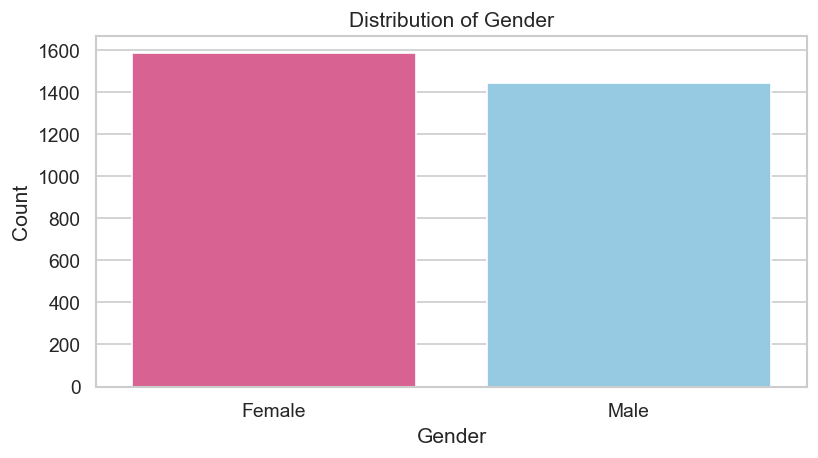

In [301]:
# Distribution of Gender (with gender colors)
if 'gender' in df.columns:
    gender_counts = df['gender'].value_counts()
    print_note('Distribution of Gender', [f"{k}: {v}" for k, v in gender_counts.items()])
    
    # Use gender-specific colors
    colors = [gender_colors.get(g, '#ec4f8e') for g in gender_counts.index]
    
    plt.figure(figsize=(7, 4))
    sns.barplot(x=gender_counts.index.astype(str), y=gender_counts.values, palette=colors)
    plt.title('Distribution of Gender')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('eda_outputs/distribution_gender.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Distribution of Income Level - Excluding Unknown
High: 1008
Medium: 883
Low: 876


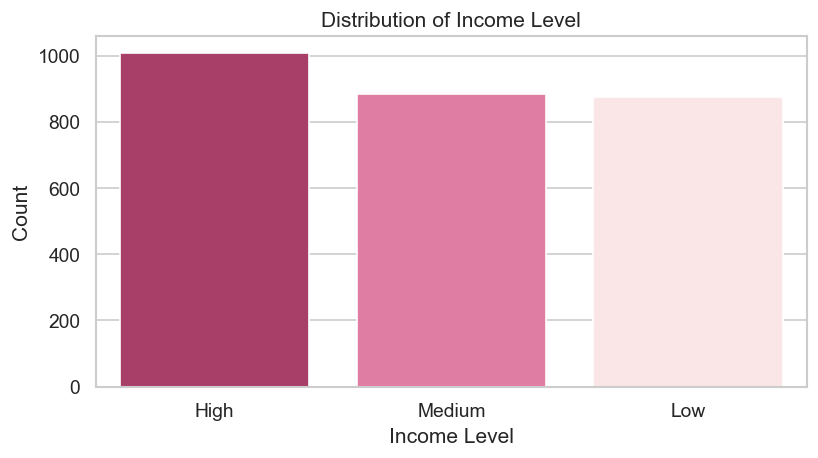

In [302]:
# Distribution of Income Level
if 'incomelevel' in df.columns:
    # FILTER OUT UNKNOWN
    df_filtered = df[df['incomelevel'].notna() & (df['incomelevel'].astype(str).str.lower() != 'unknown')].copy()
    income_counts = df_filtered['incomelevel'].value_counts()
    print_note('Distribution of Income Level - Excluding Unknown', [f"{k}: {v}" for k, v in income_counts.items()])
    plt.figure(figsize=(7, 4))
    sns.barplot(x=income_counts.index.astype(str), y=income_counts.values, palette=use_palette(len(income_counts)))
    plt.title('Distribution of Income Level')
    plt.xlabel('Income Level')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('eda_outputs/distribution_income_level.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Distribution of Location (Top 10)
West David: 19
New Anthonyland: 18
Port Austin: 16
Emilyville: 15
South Samanthaburgh: 15
Johnsonburgh: 15
East Annaview: 15
New Douglasville: 12
Johnville: 12
Perezshire: 12


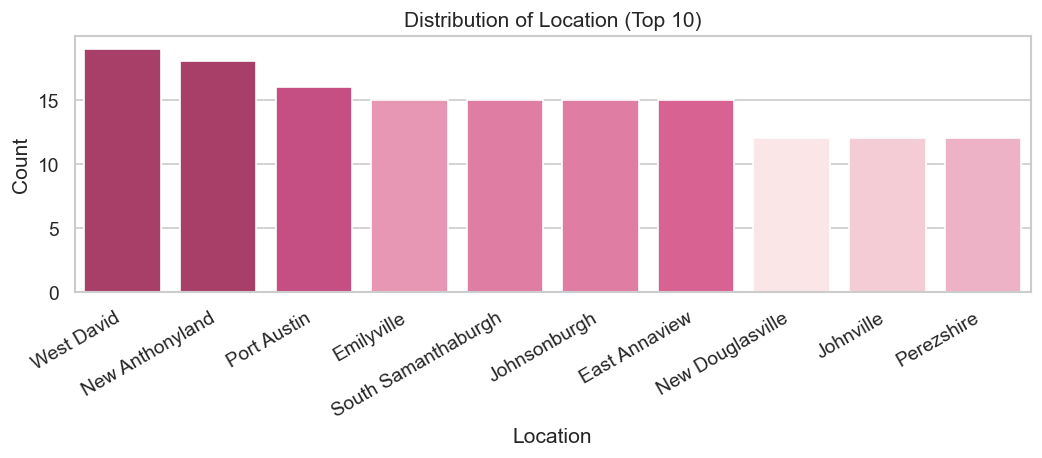

In [303]:
# Distribution of Location (Top 10)
if 'location' in df.columns:
    location_counts = df['location'].value_counts().head(10)
    print_note('Distribution of Location (Top 10)', [f"{k}: {v}" for k, v in location_counts.items()])
    
    # Get the counts in descending order (already sorted from value_counts)
    # Assign colors: highest count = darkest, lowest count = lightest
    sorted_indices = location_counts.argsort()[::-1]  # Descending order
    colors_mapped = [''] * len(location_counts)
    palette = use_palette(len(location_counts))
    
    # Map colors: first item (highest) gets darkest color
    for rank, idx in enumerate(sorted_indices):
        colors_mapped[idx] = palette[rank]
    
    plt.figure(figsize=(9, 4))
    ax = sns.barplot(x=location_counts.index.astype(str), y=location_counts.values, palette=colors_mapped)
    plt.title('Distribution of Location (Top 10)')
    plt.xlabel('Location')
    plt.ylabel('Count')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.savefig('eda_outputs/distribution_top_10_location.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Customer Count by Age Group
≤18: 85
19–25: 319
26–35: 439
36–50: 996
51–65: 857
66+: 297


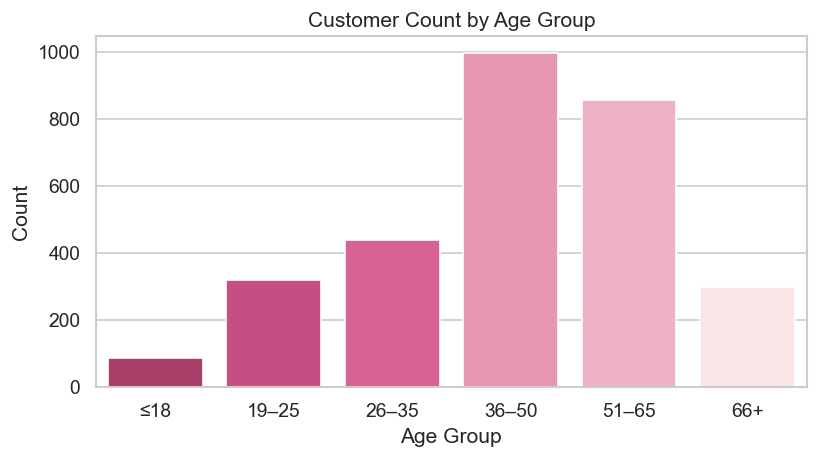

In [304]:
# Age Groups
if 'age' in df.columns:
    age = df['age'].where(df['age'].ge(0))
    bins = [0, 18, 25, 35, 50, 65, np.inf]
    labels = ['≤18', '19–25', '26–35', '36–50', '51–65', '66+']
    df['age_group'] = pd.cut(age, bins=bins, labels=labels, include_lowest=True)

if 'age_group' in df.columns:
    cnt = df['age_group'].value_counts().reindex(['≤18', '19–25', '26–35', '36–50', '51–65', '66+'], fill_value=0)
    print_note('Customer Count by Age Group', [f"{i}: {v}" for i, v in cnt.items()])
    plt.figure(figsize=(7, 4))
    sns.barplot(x=cnt.index, y=cnt.values, palette=use_palette(len(cnt)))
    plt.title('Customer Count by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('eda_outputs/customer_count_age_group.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

## B) Business-Focused Visualizations

Top 10 Product Categories (Revenue) - Excluding Unknown
Automotive: 301347.61
Clothing: 286620.00
Electronics: 275859.43
Home & Garden: 258285.30
Health & Beauty: 236332.25


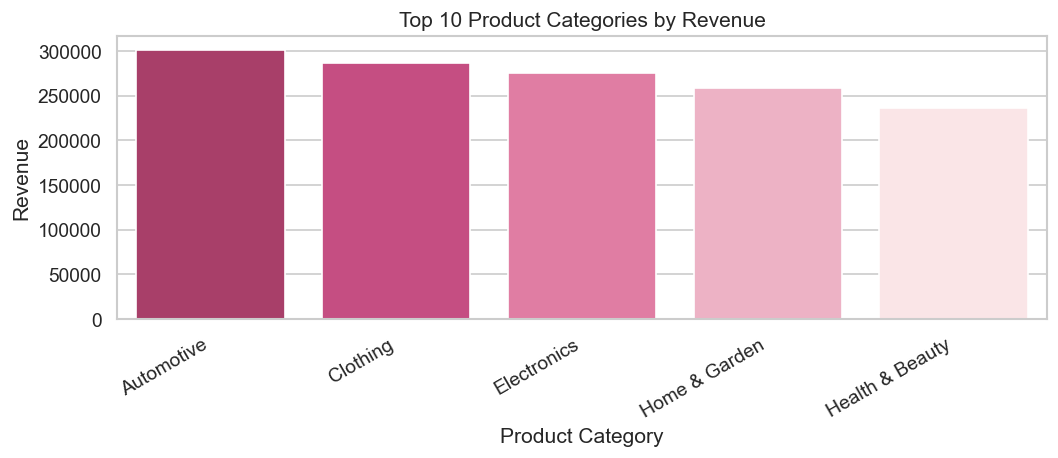

In [305]:
# Top 10 Product Categories (Revenue) - Excluding Unknown
cat_col = None
for c in ['productcategory', 'product_category']:
    if c in df.columns:
        cat_col = c
        break

amt_col = None
for c in ['amount', 'total_spent', 'avg_spent']:
    if c in df.columns:
        amt_col = c
        break

if cat_col and amt_col:
    df_filtered = df[df[cat_col].notna() & (df[cat_col].astype(str).str.lower() != 'unknown')].copy()
    top10 = df_filtered.groupby(cat_col, dropna=True)[amt_col].sum().sort_values(ascending=False).head(10)
    print_note('Top 10 Product Categories (Revenue) - Excluding Unknown', [f"{i}: {v:.2f}" for i, v in top10.items()])
    plt.figure(figsize=(9, 4))
    sns.barplot(x=top10.index.astype(str), y=top10.values, palette=use_palette(len(top10)))
    plt.title('Top 10 Product Categories by Revenue')
    plt.xlabel('Product Category')
    plt.ylabel('Revenue')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.savefig('eda_outputs/top_10_product_categories.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Top 10 Product Categories by Gender (Revenue)
Automotive: Female=168740.66, Male=132606.95
Clothing: Female=150858.83, Male=135761.17
Electronics: Female=142757.36, Male=133102.08
Home & Garden: Female=142306.57, Male=115978.74
Health & Beauty: Female=120766.88, Male=115565.37


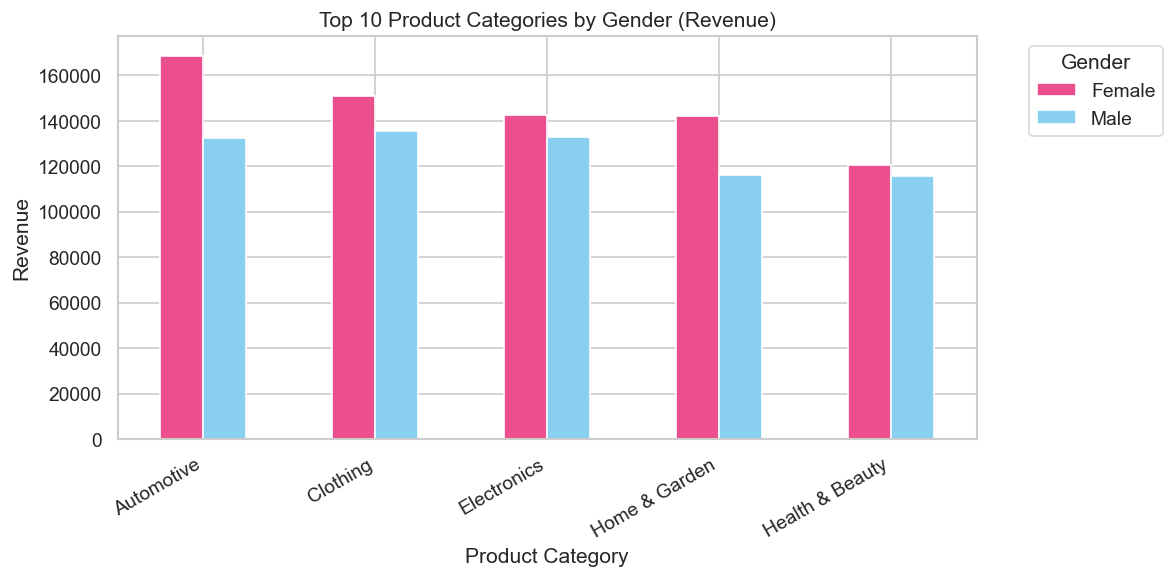

In [306]:
# Top 10 Product Categories by Gender - WITH GENDER COLORS
if cat_col and amt_col and 'gender' in df.columns:
    sub = df[[cat_col, 'gender', amt_col]].copy()
    sub = sub[sub[cat_col].notna() & (sub[cat_col].astype(str).str.lower() != 'unknown')]
    sub = sub[sub['gender'].notna() & (sub['gender'].astype(str).str.lower() != 'unknown')]
    sub[cat_col] = sub[cat_col].astype(str)
    
    cat_tot = sub.groupby(cat_col)[amt_col].sum().sort_values(ascending=False)
    top10_idx = cat_tot.head(10).index
    tab = sub.pivot_table(index=cat_col, columns='gender', values=amt_col, aggfunc='sum', fill_value=0).loc[top10_idx]
    print_note('Top 10 Product Categories by Gender (Revenue)', 
               [f"{row}: " + ', '.join(f"{col}={tab.loc[row, col]:.2f}" for col in tab.columns) for row in tab.index])
    
    # Use gender-specific colors
    colors_for_plot = [gender_colors.get(col, '#ec4f8e') for col in tab.columns]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    tab.plot(kind='bar', ax=ax, color=colors_for_plot)
    plt.title('Top 10 Product Categories by Gender (Revenue)')
    plt.xlabel('Product Category')
    plt.ylabel('Revenue')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('eda_outputs/top_10_product_categories_by_gender.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Platforms by Gender (counts)
Facebook: Female=470, Male=440
Instagram: Female=482, Male=456
Twitter: Female=523, Male=421


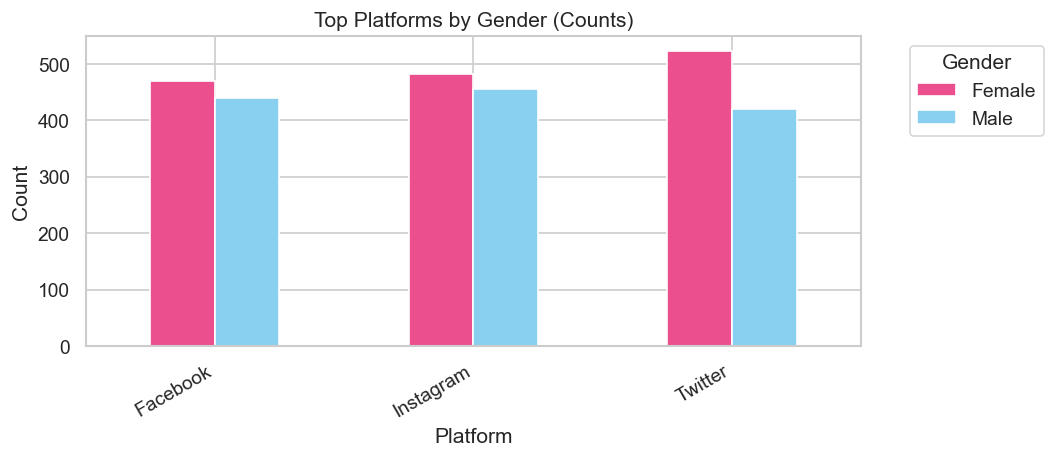

In [307]:
# Platforms by Gender - WITH GENDER COLORS
# Detect platform column if not already set
plat_col = None
for c in ['platform', 'platform_name', 'platforms']:
    if c in df.columns:
        plat_col = c
        break

if plat_col and 'gender' in df.columns:
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered[plat_col].notna() & (df_filtered[plat_col].astype(str).str.lower() != 'unknown')]
    df_filtered = df_filtered[df_filtered['gender'].notna() & (df_filtered['gender'].astype(str).str.lower() != 'unknown')]
    
    tab = pd.crosstab(df_filtered[plat_col], df_filtered['gender'])
    print_note('Platforms by Gender (counts)', 
               [f"{i}: " + ', '.join(f"{c}={tab.loc[i, c]}" for c in tab.columns) for i in tab.index])
    
    # Use gender-specific colors
    colors_for_plot = [gender_colors.get(col, '#ec4f8e') for col in tab.columns]
    
    fig, ax = plt.subplots(figsize=(9, 4))
    tab.plot(kind='bar', ax=ax, color=colors_for_plot)
    plt.title('Top Platforms by Gender (Counts)')
    plt.xlabel('Platform')
    plt.ylabel('Count')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('eda_outputs/distribution_top_10_platforms_gender.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

High Spender Rate by Gender
Male: 42.55%
Female: 39.57%


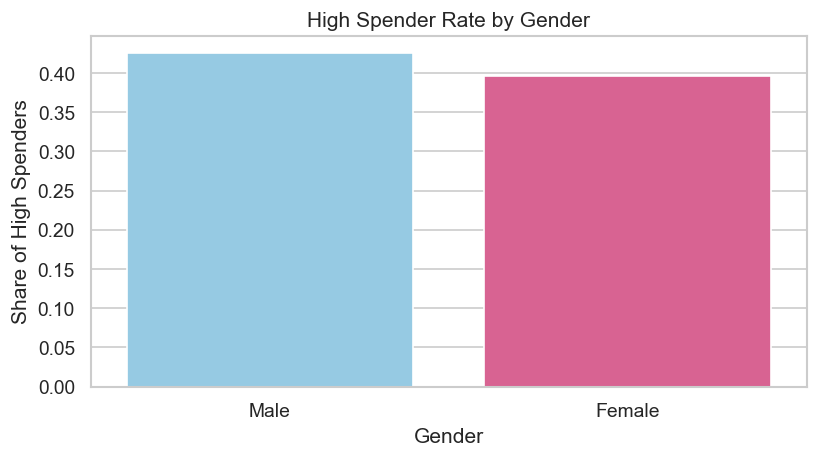

In [308]:
# High Spender Rate by Gender - WITH GENDER COLORS
# Ensure flag_col is available (handle cases where the cell that sets it wasn't run)
if 'flag_col' not in globals() or flag_col is None:
    flag_col = None
    for c in ['ishighspender', 'high_spender', 'is_high_spender']:
        if c in df.columns:
            flag_col = c
            break

if flag_col and 'gender' in df.columns:
    sub = df[['gender', flag_col]].copy()
    sub[flag_col] = pd.to_numeric(sub[flag_col], errors='coerce').fillna(0)
    rate = sub.groupby('gender')[flag_col].mean().sort_values(ascending=False)
    print_note('High Spender Rate by Gender', [f"{g}: {v:.2%}" for g, v in rate.items()])
    
    # Use gender-specific colors
    colors_for_plot = [gender_colors.get(g, '#ec4f8e') for g in rate.index]
    
    plt.figure(figsize=(7, 4))
    sns.barplot(x=rate.index.astype(str), y=rate.values, palette=colors_for_plot)
    plt.title('High Spender Rate by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Share of High Spenders')
    plt.tight_layout()
    plt.savefig('eda_outputs/high_spender_rate_by_gender.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()
else:
    print_note('High Spender Rate by Gender', f'Skipped - flag_col not found or gender column missing. flag_col={flag_col}')

Total Transactions per Payment Method - Excluding Unknown
Debit Card: 809
PayPal: 759
Credit Card: 756
Bank Transfer: 706


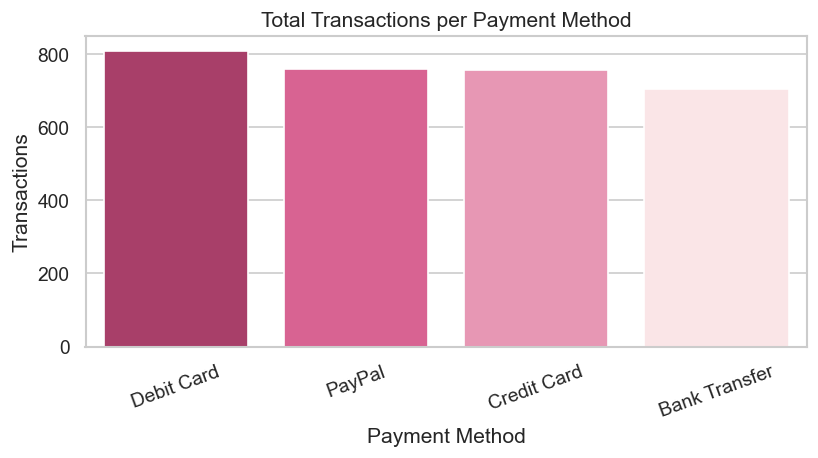

In [309]:
# Total Transactions per Payment Method - Excluding Unknown
pay_col = None
for c in ['paymentmethod', 'payment_method']:
    if c in df.columns:
        pay_col = c
        break

if pay_col:
    df_filtered = df[df[pay_col].notna() & (df[pay_col].astype(str).str.lower() != 'unknown')].copy()
    txc = df_filtered[pay_col].value_counts()
    print_note('Total Transactions per Payment Method - Excluding Unknown', [f"{k}: {v}" for k, v in txc.items()])
    plt.figure(figsize=(7, 4))
    sns.barplot(x=txc.index.astype(str), y=txc.values, palette=use_palette(len(txc)))
    plt.title('Total Transactions per Payment Method')
    plt.xlabel('Payment Method')
    plt.ylabel('Transactions')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig('eda_outputs/total_transactions_per_payment_method.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

## C) Statistical Tests – ANOVA


ANOVA for total_spent by gender:
F-statistic: -0.0000, p-value: nan
Result: No significant differences between groups.


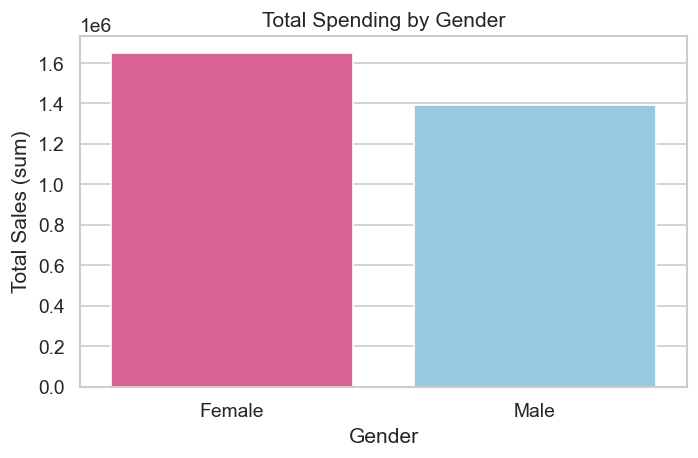

In [310]:
# ANOVA: Total Spending by Gender - WITH GENDER COLORS
if 'gender' in df.columns and 'total_spent' in df.columns:
    groups = [df['total_spent'].dropna().values for _, g in df[['total_spent', 'gender']].dropna().groupby('gender')]
    valid = [g for g in groups if len(g) > 1]
    
    if len(valid) >= 2:
        F, p = stats.f_oneway(*valid)
        print('\nANOVA for total_spent by gender:')
        print(f'F-statistic: {F:.4f}, p-value: {p:.4g}')
        print('Result:', 'Significant differences between groups.' if p < 0.05 else 'No significant differences between groups.')
        
        order = df['gender'].unique()
        colors_for_plot = [gender_colors.get(g, '#ec4f8e') for g in order]
        
        plt.figure(figsize=(6, 4))
        sns.barplot(data=df, x='gender', y='total_spent', estimator=sum, errorbar=None, order=order, palette=colors_for_plot)
        plt.title('Total Spending by Gender')
        plt.xlabel('Gender')
        plt.ylabel('Total Sales (sum)')
        plt.tight_layout()
        plt.savefig('eda_outputs/anova_total_spent_by_gender.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
        plt.show()


ANOVA for total_spent by age_group:
F-statistic: -0.0000, p-value: nan
Result: No significant differences between groups.


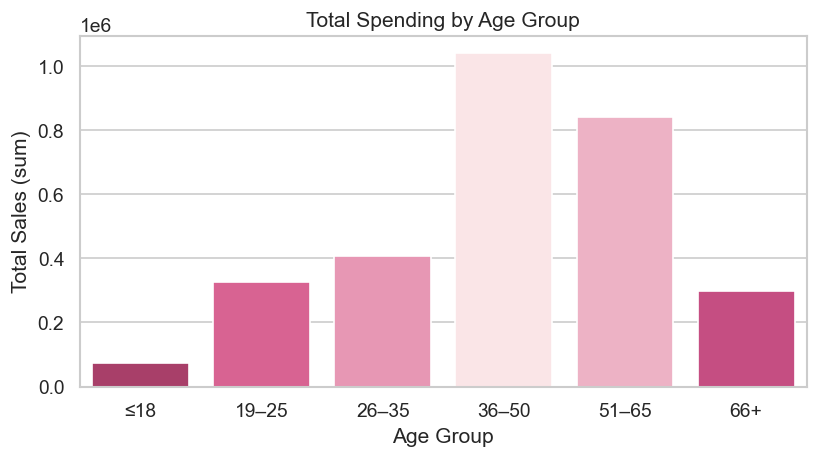

In [311]:
# ANOVA: Total Spending by Age Group
if 'age_group' in df.columns and 'total_spent' in df.columns:
    if not isinstance(df['age_group'].dtype, pd.CategoricalDtype):
        df['age_group'] = df['age_group'].astype('category')
    
    groups = [df['total_spent'].dropna().values for _, g in df[['total_spent', 'age_group']].dropna().groupby('age_group', observed=True)]
    valid = [g for g in groups if len(g) > 1]
    
    if len(valid) >= 2:
        F, p = stats.f_oneway(*valid)
        print('\nANOVA for total_spent by age_group:')
        print(f'F-statistic: {F:.4f}, p-value: {p:.4g}')
        print('Result:', 'Significant differences between groups.' if p < 0.05 else 'No significant differences between groups.')
        
        order = ['≤18', '19–25', '26–35', '36–50', '51–65', '66+']
        
        # Calculate sum for each age group to assign colors
        age_sums = df.groupby('age_group', observed=True)['total_spent'].sum().reindex(order, fill_value=0)
        
        # Create color mapping (highest value gets darkest)
        sorted_indices = age_sums.argsort()
        colors_mapped = [''] * len(age_sums)
        palette = use_palette(len(age_sums))
        
        for rank, idx in enumerate(sorted_indices):
            colors_mapped[idx] = palette[rank]
        
        plt.figure(figsize=(7, 4))
        sns.barplot(data=df, x='age_group', y='total_spent', estimator=sum, errorbar=None, order=order, palette=colors_mapped)
        plt.title('Total Spending by Age Group')
        plt.xlabel('Age Group')
        plt.ylabel('Total Sales (sum)')
        plt.tight_layout()
        plt.savefig('eda_outputs/total_spent_by_age_group.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
        plt.show()

## D) Distributions & Outliers

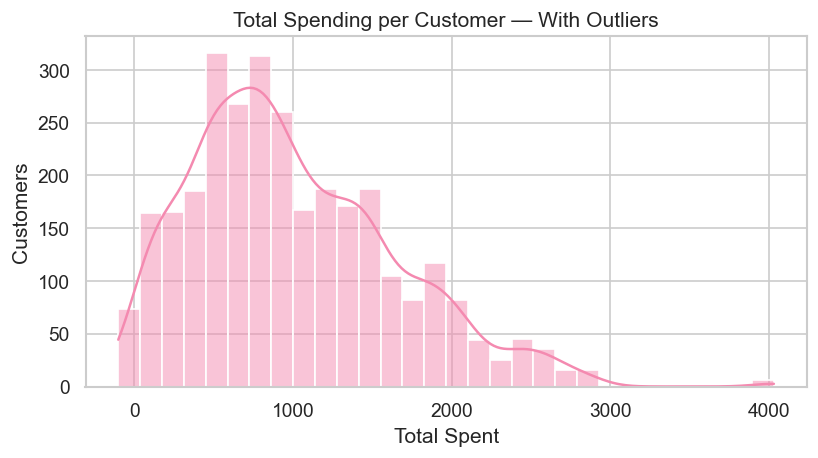

Boxplot – total_spent
Mode: with. Raw data with potential outliers.


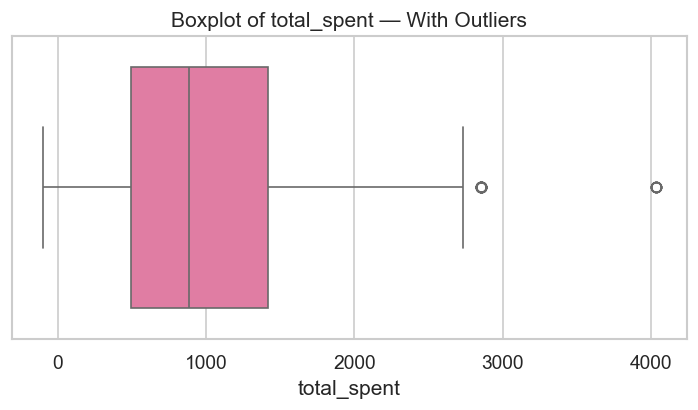

Boxplot – avg_spent
Mode: with. Raw data with potential outliers.


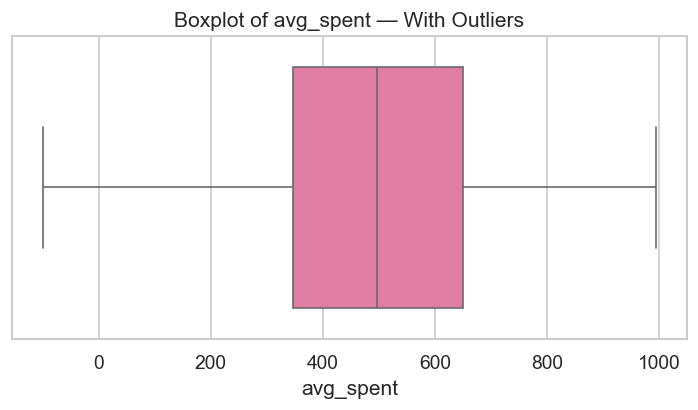

Boxplot – max_transaction
Mode: with. Raw data with potential outliers.


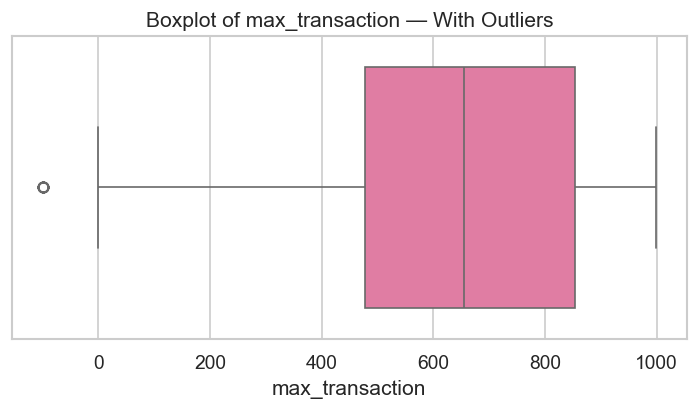

Boxplot – min_transaction
Mode: with. Raw data with potential outliers.


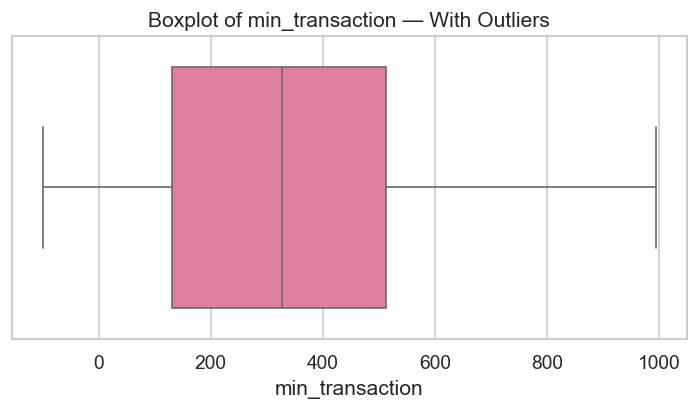

In [312]:
# ===================== Unified Outlier Policy & Plots (WITH outliers) =====================

MODE = "with"   # <-- WITH outliers

# Ensure pink_grad is available (fallback to pink_grad_reversed or a default palette)
if 'pink_grad' not in globals():
    if 'pink_grad_reversed' in globals():
        pink_grad = pink_grad_reversed
    else:
        pink_grad = ['#ba2d65', '#d93a7f', '#ec4f8e', '#f06d9f', '#f48ab0', '#f7a8c2', '#fac5d3', '#fde2e4']

# --- Helpers ---
def iqr_bounds(s: pd.Series, k: float = 1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr

# --- Pick the base dataframe once (single source of truth for both plots & report) ---
BASE = df  # since MODE == "with"

# --- Histogram for total_spent (if exists) ---
if "total_spent" in BASE.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(BASE["total_spent"].dropna(), bins=30, kde=True, color=pink_grad[4])
    plt.title("Total Spending per Customer — With Outliers")
    plt.xlabel("Total Spent")
    plt.ylabel("Customers")
    plt.tight_layout()
    plt.savefig("eda_outputs/distribution_total_spending_customers.png", dpi=300, bbox_inches="tight")
    plt.show()

# --- Box plots (WITH outliers; single source: BASE) ---
for col in ["total_spent", "avg_spent", "max_transaction", "min_transaction"]:
    if col in BASE.columns:
        try:
            print_note(f"Boxplot – {col}", ["Mode: with. Raw data with potential outliers."])
        except NameError:
            pass
        plt.figure(figsize=(6, 3.6))
        sns.boxplot(x=BASE[col].dropna(), color=pink_grad[3], showfliers=True)  # show outliers
        plt.title(f"Boxplot of {col} — With Outliers")
        plt.tight_layout()
        plt.savefig(f"eda_outputs/distribution_{col}_customers.png", dpi=300, bbox_inches="tight")
        plt.show()

## E) IQR Outlier Detection & Analysis

In [313]:
# ===================== IQR Outlier Detection Report =====================
print("\n" + "="*60)
print("IQR OUTLIER DETECTION — using BASE = df (WITH outliers)")
print("="*60)

numeric_cols = BASE.select_dtypes(include=["number"]).columns.tolist()
outlier_summary = []

for col in numeric_cols:
    s = BASE[col].dropna()
    if s.empty:
        outlier_summary.append({"column": col, "outliers": 0, "lower": np.nan, "upper": np.nan})
        continue

    lb, ub = iqr_bounds(s)  # consistent bounds function
    outliers = ((s < lb) | (s > ub)).sum()
    outlier_summary.append({
        "column": col,
        "outliers": int(outliers),
        "lower": float(lb),
        "upper": float(ub)
    })
    print(f"{col}: {outliers} potential outliers")

outlier_df = pd.DataFrame(outlier_summary).sort_values("outliers", ascending=False)
print("\nOutlier Summary (WITH outliers mode):")
print(outlier_df.to_string(index=False))
print(f"\nBASE data shape: {BASE.shape}")


IQR OUTLIER DETECTION — using BASE = df (WITH outliers)
age: 30 potential outliers
total_spent: 22 potential outliers
avg_spent: 0 potential outliers
num_transactions: 0 potential outliers
max_transaction: 14 potential outliers
min_transaction: 0 potential outliers
engagement_score: 0 potential outliers
ishighspender: 0 potential outliers
amount: 0 potential outliers

Outlier Summary (WITH outliers mode):
          column  outliers      lower      upper
             age        30   -3.00000   93.00000
     total_spent        22 -884.97625 2799.29375
 max_transaction        14  -87.17500 1419.10500
       avg_spent         0 -107.49875 1103.73125
num_transactions         0   -2.00000    6.00000
 min_transaction         0 -441.65000 1085.15000
engagement_score         0   -2.00000    6.00000
   ishighspender         0   -1.50000    2.50000
          amount         0 -468.99250 1452.70750

BASE data shape: (3030, 24)


## F) Key Relationships (Scatter) – Post-clean

Correlation (Pearson) – #Transactions vs Total Spend
r = 0.763, p = 0


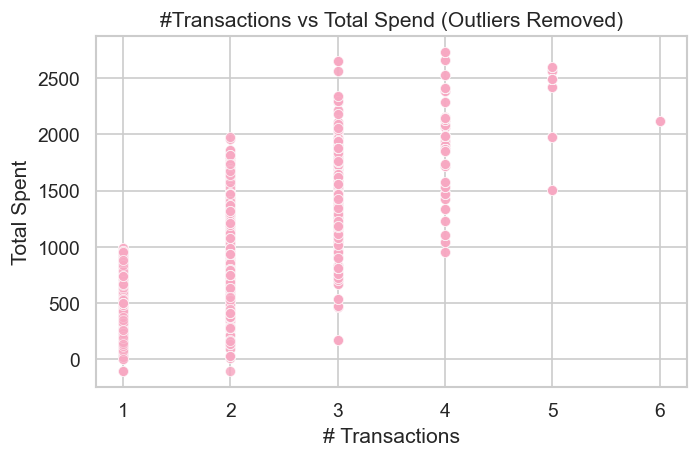

Correlation (Pearson) – Age vs Total Spend
r = -0.023, p = 0.216


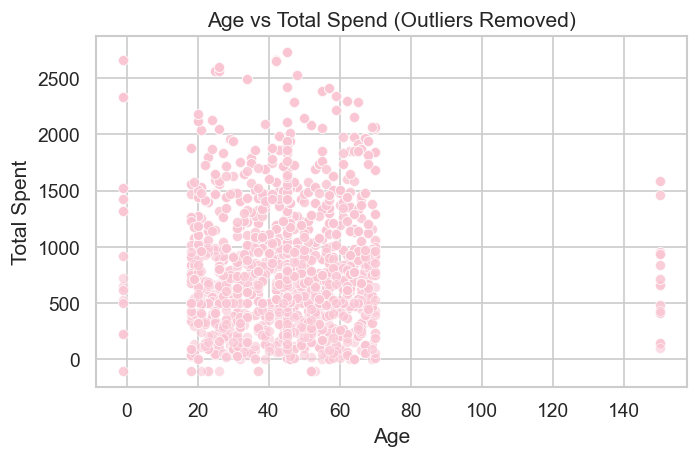

In [314]:
if 'num_transactions' in df_no.columns and 'total_spent' in df_no.columns:
    r, p = safe_pearson(df_no['num_transactions'], df_no['total_spent'])
    print_note('Correlation (Pearson) – #Transactions vs Total Spend', [f'r = {r:.3f}, p = {p:.3g}'])
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='num_transactions', y='total_spent', data=df_no, alpha=0.6, color=pink_grad[5])
    plt.title('#Transactions vs Total Spend (Outliers Removed)')
    plt.xlabel('# Transactions')
    plt.ylabel('Total Spent')
    plt.tight_layout()
    plt.savefig('eda_outputs/scatter_transactions_vs_spent.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

if 'age' in df_no.columns and 'total_spent' in df_no.columns:
    r, p = safe_pearson(df_no['age'], df_no['total_spent'])
    print_note('Correlation (Pearson) – Age vs Total Spend', [f'r = {r:.3f}, p = {p:.3g}'])
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='age', y='total_spent', data=df_no, alpha=0.6, color=pink_grad[6])
    plt.title('Age vs Total Spend (Outliers Removed)')
    plt.xlabel('Age')
    plt.ylabel('Total Spent')
    plt.tight_layout()
    plt.savefig('eda_outputs/scatter_age_vs_spent.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

## G) Pearson Correlation Significance Test

In [315]:
# Pearson Correlation Significance Test
print("\n" + "="*60)
print("PEARSON CORRELATION SIGNIFICANCE TEST")
print("="*60 + "\n")

numeric_cols = df_no.select_dtypes(include=['number']).columns.tolist()
results = []

for a, b in combinations(numeric_cols, 2):
    x = pd.to_numeric(df_no[a], errors='coerce')
    y = pd.to_numeric(df_no[b], errors='coerce')
    ok = x.notna() & y.notna()
    
    if ok.sum() > 2:
        r, p = stats.pearsonr(x[ok], y[ok])
        results.append(f"{a} vs {b} → r = {r:+.3f}, p = {p:.4f}")
        print(f"{a} vs {b} → r = {r:+.3f}, p = {p:.4f}")

print("\nTotal correlation pairs tested:", len(results))


PEARSON CORRELATION SIGNIFICANCE TEST

age vs total_spent → r = -0.023, p = 0.2163
age vs avg_spent → r = +0.021, p = 0.2450
age vs num_transactions → r = -0.030, p = 0.1040
age vs max_transaction → r = +0.006, p = 0.7450
age vs min_transaction → r = +0.016, p = 0.3744
age vs engagement_score → r = +0.070, p = 0.0001
age vs ishighspender → r = -0.025, p = 0.1703
age vs amount → r = +0.017, p = 0.3543
total_spent vs avg_spent → r = +0.551, p = 0.0000
total_spent vs num_transactions → r = +0.763, p = 0.0000
total_spent vs max_transaction → r = +0.777, p = 0.0000
total_spent vs min_transaction → r = +0.186, p = 0.0000
total_spent vs engagement_score → r = +0.012, p = 0.5221
total_spent vs ishighspender → r = +0.828, p = 0.0000
total_spent vs amount → r = +0.439, p = 0.0000
avg_spent vs num_transactions → r = -0.038, p = 0.0366
avg_spent vs max_transaction → r = +0.832, p = 0.0000
avg_spent vs min_transaction → r = +0.855, p = 0.0000
avg_spent vs engagement_score → r = +0.009, p = 0.6111


## H) Categorical Associations – Cramér's V + Chi-Square

Association Matrix (Core Categoricals – Cramér's V)
median V = 0.033


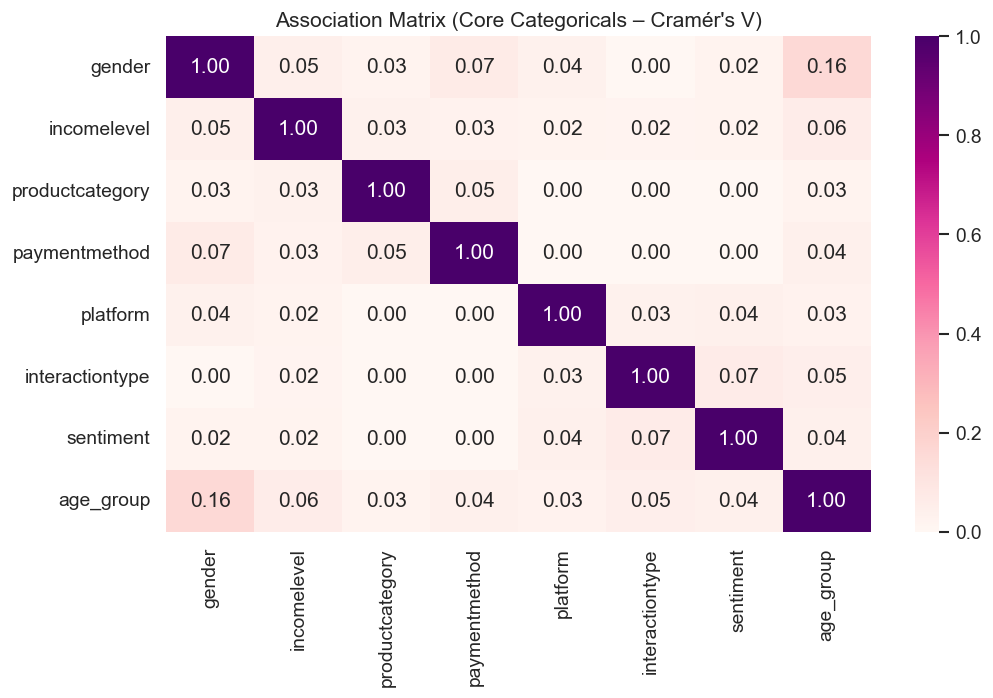

Association Matrix (Additional Categoricals – Cramér's V)
median V = 0.793


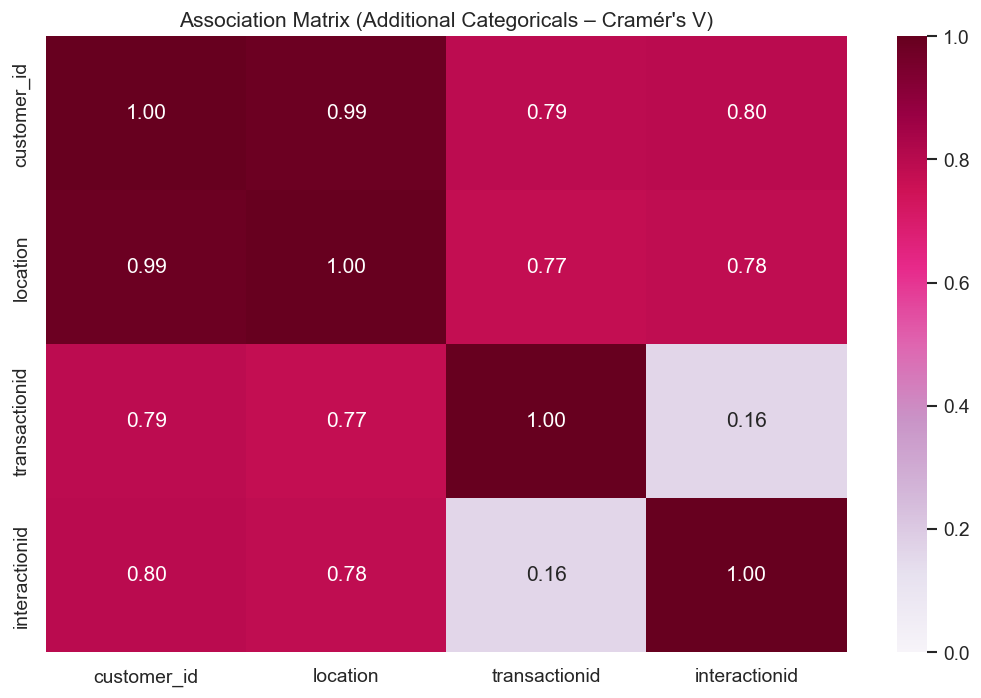

In [316]:
cat_cols = [c for c in df.columns if df[c].dtype == 'O']
cat_cols = [c for c in cat_cols if df[c].nunique(dropna=True) > 1]

def cramers_matrix(cols, title, cmap='RdPu'):
    if len(cols) < 2:
        return
    A = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            if i <= j:
                v = 1.0 if c1 == c2 else cramers_v(df[c1], df[c2])
                A.loc[c1, c2] = A.loc[c2, c1] = v
    print_note(title, [f'median V = {np.nanmedian(A.values):.3f}'])
    plt.figure(figsize=(9, 6))
    sns.heatmap(A, annot=True, cmap=cmap, vmin=0, vmax=1, fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'eda_outputs/{title.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("–", "-")}.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

core_cats = [c for c in ['gender', 'incomelevel', 'productcategory', 'paymentmethod', 'platform', 'interactiontype', 'sentiment', 'age_group'] if c in df.columns]
if len(core_cats) >= 2:
    cramers_matrix(core_cats, "Association Matrix (Core Categoricals – Cramér's V)", cmap='RdPu')

other_cats = [c for c in cat_cols if c not in core_cats][:8]
if len(other_cats) >= 2:
    # Use a lighter, more appealing color scheme
    cramers_matrix(other_cats, "Association Matrix (Additional Categoricals – Cramér's V)", cmap='PuRd')

## I) Chi-Square Tests – Top 3 Most Significant


CHI-SQUARE TESTS — CATEGORICAL ASSOCIATIONS
Automatically detects suitable categorical column pairs, prints chi-square statistics,
then shows simple bar charts for the top results.

Chi-Square summary (top 10 by significance):

gender vs age_group → Chi2: 78.3071, p-value: 1.896e-15, dof=5, N=2993
incomelevel vs age_group → Chi2: 47.9897, p-value: 2.553e-05, dof=15, N=2993
interactiontype vs sentiment → Chi2: 33.9977, p-value: 4.067e-05, dof=8, N=3030
gender vs paymentmethod → Chi2: 17.7110, p-value: 0.0005045, dof=3, N=3030
productcategory vs paymentmethod → Chi2: 38.9153, p-value: 0.0006598, dof=15, N=3030
platform vs sentiment → Chi2: 28.5607, p-value: 0.004576, dof=12, N=3030
sentiment vs age_group → Chi2: 40.0044, p-value: 0.004989, dof=20, N=2993
interactiontype vs age_group → Chi2: 24.6056, p-value: 0.006145, dof=10, N=2993
paymentmethod vs age_group → Chi2: 29.2724, p-value: 0.01483, dof=15, N=2993
gender vs incomelevel → Chi2: 9.6215, p-value: 0.02207, dof=3, N=3030

Chi-Squa

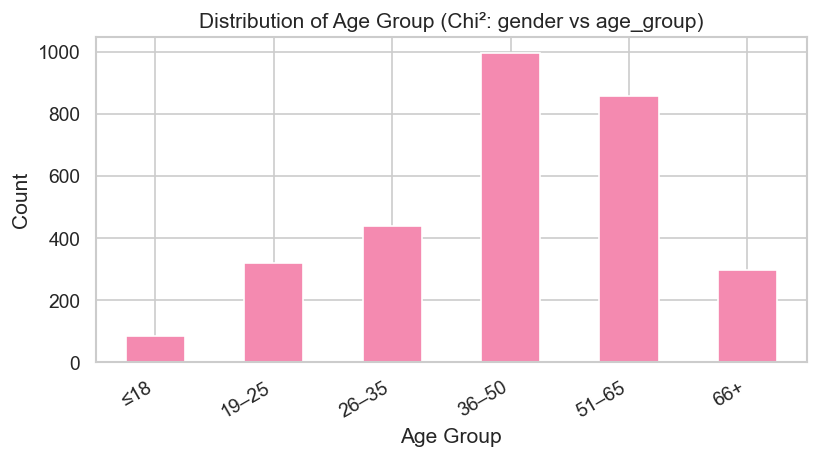


Chi-Square Test for incomelevel vs age_group:
Chi2: 47.9897, p-value: 2.553e-05
Result: Significant association.


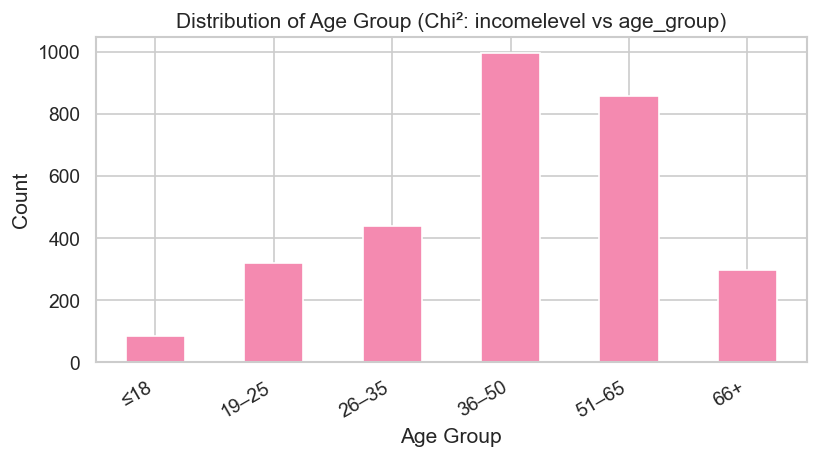


Chi-Square Test for interactiontype vs sentiment:
Chi2: 33.9977, p-value: 4.067e-05
Result: Significant association.


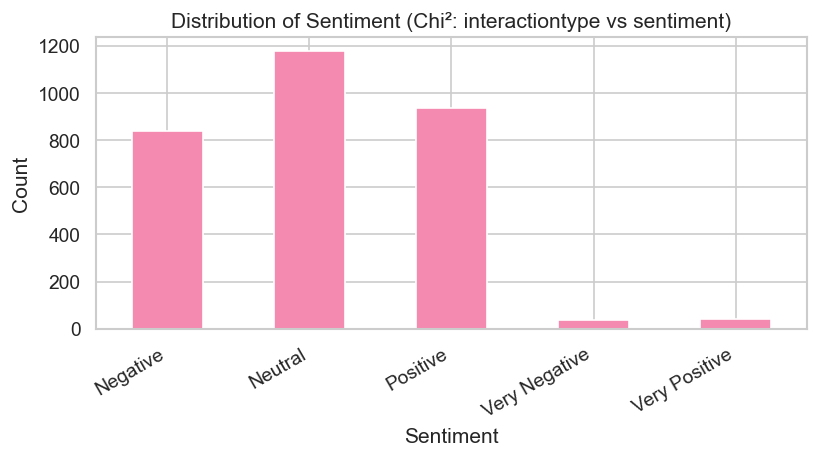

In [317]:
# Chi-Square Tests for Categorical Associations
print("\n" + "="*60)
print("CHI-SQUARE TESTS — CATEGORICAL ASSOCIATIONS")
print("="*60)
print("Automatically detects suitable categorical column pairs, prints chi-square statistics,")
print("then shows simple bar charts for the top results.\n")

# Detect categorical columns
cat_cols = [c for c in df.columns
            if (df[c].dtype == "object" or str(df[c].dtype).startswith("category"))
            and df[c].nunique(dropna=True) >= 2
            and df[c].nunique(dropna=True) <= 20]

results = []
for c1, c2 in combinations(cat_cols, 2):
    tab = pd.crosstab(df[c1], df[c2])
    if tab.shape[0] > 1 and tab.shape[1] > 1:
        chi2, p, dof, exp = stats.chi2_contingency(tab)
        results.append((c1, c2, chi2, p, dof, tab.sum().sum()))

if results:
    results.sort(key=lambda x: x[3])  # sort by p-value
    print("Chi-Square summary (top 10 by significance):\n")
    for c1, c2, chi2, p, dof, n in results[:10]:
        print(f"{c1} vs {c2} → Chi2: {chi2:.4f}, p-value: {p:.4g}, dof={dof}, N={n}")
    
    # Plot bar charts for the top 3 most significant with DISTINCT TITLES
    max_plots = 3
    plotted = 0
    for c1, c2, chi2, p, dof, n in results:
        if plotted >= max_plots:
            break
        print(f"\nChi-Square Test for {c1} vs {c2}:")
        print(f"Chi2: {chi2:.4f}, p-value: {p:.4g}")
        print("Result:", "Significant association." if p < 0.05 else "No significant association.")
        
        # DISTINCT TITLE FOR EACH CHART
        chart_title = f"Distribution of {c2.replace('_', ' ').title()} (Chi²: {c1} vs {c2})"
        
        plt.figure(figsize=(7, 4))
        tab = pd.crosstab(df[c1], df[c2])
        tab.sum(axis=0).plot(kind="bar", color=pink_grad[4])
        plt.ylabel("Count")
        plt.title(chart_title)  # UNIQUE TITLE
        plt.xlabel(c2.replace('_', ' ').title())
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        
        # AUTO-SAVE with unique filename
        filename = f'chi_square_{c1}_vs_{c2}.png'
        plt.savefig(f'eda_outputs/{filename}', dpi=300, bbox_inches='tight')  # AUTO-SAVE
        plt.show()
        plotted += 1
else:
    print("No suitable categorical pairs found for chi-square.")

## J) Revenue Over Time + ADF

Monthly Revenue (All Months)
2022-07: 65721.96
2022-08: 47202.28
2022-09: 58459.53
2022-10: 61232.29
2022-11: 70249.09
2022-12: 70625.52
2023-01: 53263.49
2023-02: 48012.75
2023-03: 51737.82
2023-04: 43806.18
2023-05: 61254.06
2023-06: 53525.05
2023-07: 76582.10
2023-08: 70188.43
2023-09: 64599.71
2023-10: 61402.38
2023-11: 52533.21
2023-12: 57122.00
2024-01: 79483.86
2024-02: 55488.40
2024-03: 72761.71
2024-04: 54221.95
2024-05: 63867.46
2024-06: 51087.81


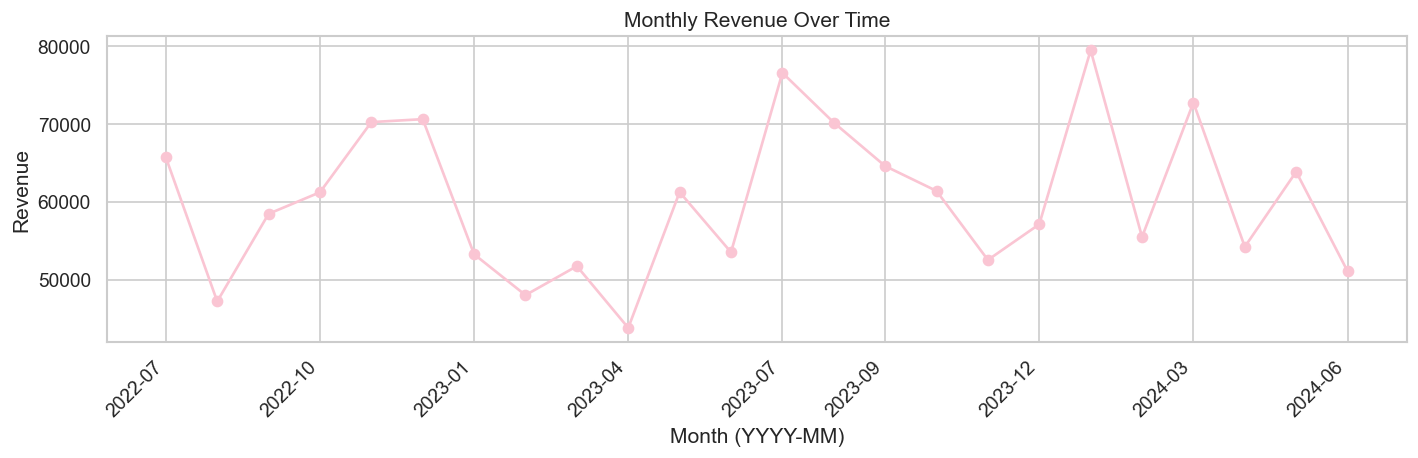

Total Yearly Revenue
2022: 373490.66
2023: 694027.18
2024: 376911.18


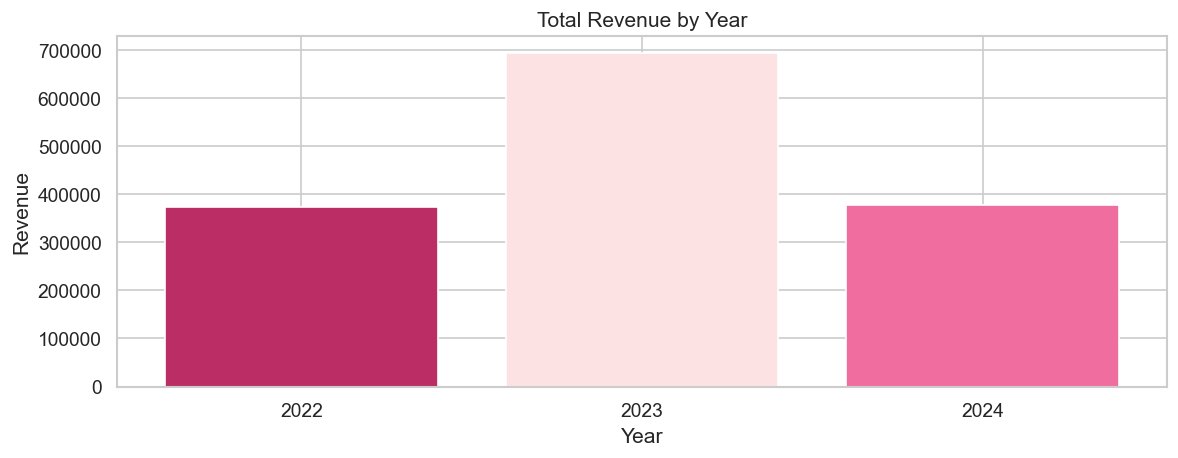

ADF Test (Monthly Revenue Series)
ADF Statistic: -4.3620
p-value: 0.0003463
n_obs: 24
Daily Revenue – 7-Day Rolling (samples)
Days: 730
Last 3 daily: [1633.36, 3890.54, 4360.35]


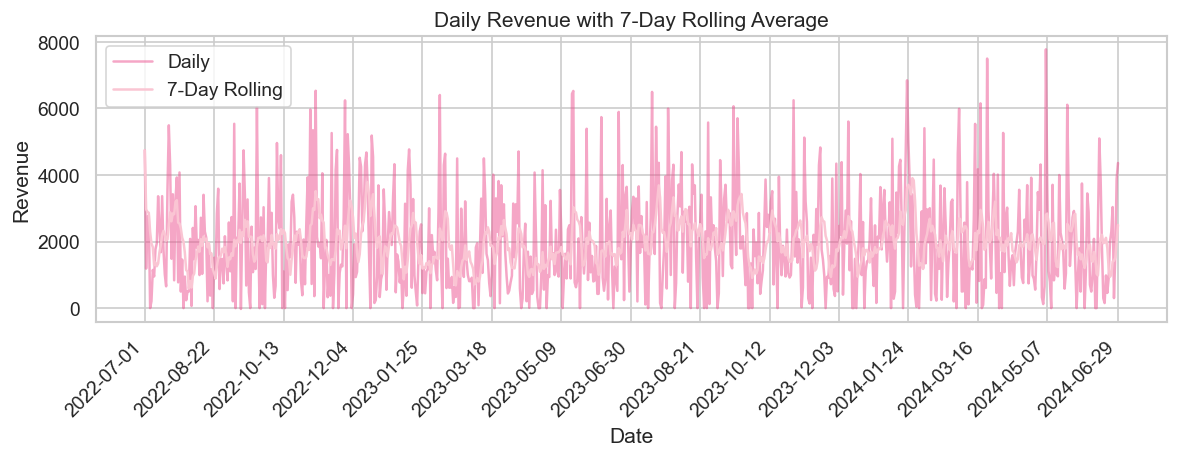

Cumulative Revenue (samples)
Final cumulative: 1444429.03


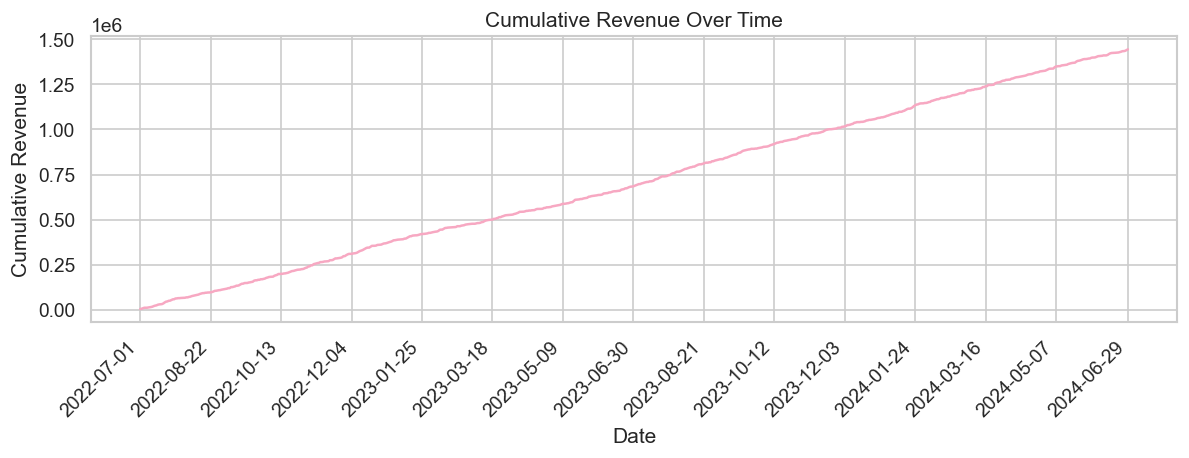

In [318]:
date_col = None
for c in ['transactiondate', 'signupdate', 'interactiondate']:
    if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c]):
        date_col = c
        break

if date_col is None:
    for c in ['transactiondate', 'signupdate', 'interactiondate']:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
            if pd.api.types.is_datetime64_any_dtype(df[c]):
                date_col = c
                break

amt_col = amt_col or ('total_spent' if 'total_spent' in df.columns else None)

if date_col and amt_col:
    tmp = df.dropna(subset=[date_col, amt_col]).set_index(date_col)[amt_col]
    
    # Monthly Revenue Over Time - limited x-axis labels (max 9)
    m = tmp.resample('MS').sum()
    if m.dropna().any():
        idx_m = m.index.strftime('%Y-%m')
        n = len(m)
        n_labels = min(9, n)
        # choose evenly spaced tick positions, ensure unique ints
        tick_positions = np.unique(np.round(np.linspace(0, max(n-1, 0), n_labels)).astype(int))
        tick_labels = [m.index[i].strftime('%Y-%m') for i in tick_positions]

        print_note('Monthly Revenue (All Months)', [f"{i}: {v:.2f}" for i, v in zip(idx_m, m.values)])

        plt.figure(figsize=(12, 4))
        plt.plot(range(n), m.values, marker='o', linewidth=1.6, color=pink_grad[6])
        plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
        plt.title('Monthly Revenue Over Time')
        plt.xlabel('Month (YYYY-MM)')
        plt.ylabel('Revenue')
        plt.tight_layout()
        plt.savefig('eda_outputs/monthly_revenue_over_time.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
        plt.show()

    # Total Revenue by Year - GRADIENT BY VALUE
    y = tmp.resample('YS').sum()
    idx_y = y.index.strftime('%Y')

    print_note('Total Yearly Revenue', [f"{i}: {v:.2f}" for i, v in zip(idx_y, y.values)])

    # Create color mapping based on revenue values (highest gets darkest)
    sorted_indices = y.argsort()
    colors_mapped = [''] * len(y)
    palette = use_palette(len(y))

    for rank, idx in enumerate(sorted_indices):
        colors_mapped[idx] = palette[rank]

    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(len(idx_y)), y.values, color=colors_mapped)
    plt.xticks(range(len(idx_y)), idx_y, rotation=0)
    plt.title('Total Revenue by Year')
    plt.xlabel('Year')
    plt.ylabel('Revenue')
    plt.tight_layout()
    plt.savefig('eda_outputs/total_yearly_revenue.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()
    
    # ADF Test
    m = tmp.resample('MS').sum()
    adf = adfuller(m.dropna())
    print_note('ADF Test (Monthly Revenue Series)', [f'ADF Statistic: {adf[0]:.4f}', f'p-value: {adf[1]:.4g}', f'n_obs: {len(m.dropna())}'])
    
    # Daily Revenue with 7-Day Rolling Average - FIXED X-AXIS
    d = tmp.resample('D').sum()
    if d.notna().any():
        r7 = d.rolling(7, min_periods=1).mean()
        print_note('Daily Revenue – 7-Day Rolling (samples)', [f'Days: {len(d)}', f'Last 3 daily: {d.tail(3).round(2).to_list()}'])
        
        fig, ax = plt.subplots(figsize=(10, 4))
        x_values = range(len(d))
        ax.plot(x_values, d.values, alpha=0.5, label='Daily', color=pink_grad[2])
        ax.plot(x_values, r7.values, label='7-Day Rolling', color=pink_grad[6])
        
        n_ticks = 15
        tick_positions = np.linspace(0, len(d)-1, n_ticks, dtype=int)
        tick_labels = [d.index[i].strftime('%Y-%m-%d') for i in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        
        plt.title('Daily Revenue with 7-Day Rolling Average')
        plt.xlabel('Date')
        plt.ylabel('Revenue')
        plt.legend()
        plt.tight_layout()
        plt.savefig('eda_outputs/daily_revenue_with_rolling_average.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
        plt.show()
        
        # Cumulative Revenue - FIXED X-AXIS
        csum = d.cumsum()
        print_note('Cumulative Revenue (samples)', [f'Final cumulative: {csum.iloc[-1]:.2f}'])
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(x_values, csum.values, color=pink_grad[5])
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        
        plt.title('Cumulative Revenue Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Revenue')
        plt.tight_layout()
        plt.savefig('eda_outputs/cumulative_revenue_over_time.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
        plt.show()

## K) Social & Engagement Views

Top Interaction Types (count) - Excluding Unknown
Share: 1040
Like: 1002
Comment: 988


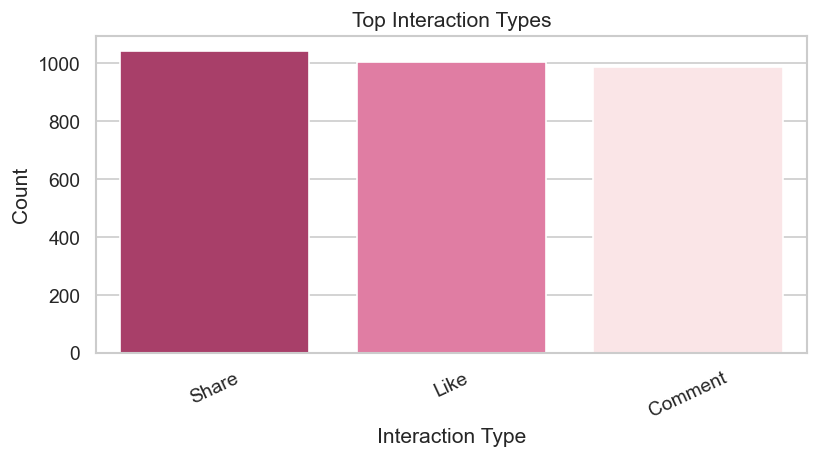

In [319]:
# Top Interaction Types - Excluding Unknown
int_col = None
for c in ['interactiontype', 'interaction_type']:
    if c in df.columns:
        int_col = c
        break

if int_col:
    df_filtered = df[df[int_col].notna() & (df[int_col].astype(str).str.lower() != 'unknown')].copy()
    top = df_filtered[int_col].value_counts().head(10)
    print_note('Top Interaction Types (count) - Excluding Unknown', [f"{k}: {v}" for k, v in top.items()])
    plt.figure(figsize=(7, 4))
    sns.barplot(x=top.index.astype(str), y=top.values, palette=use_palette(len(top)))
    plt.title('Top Interaction Types')
    plt.xlabel('Interaction Type')
    plt.ylabel('Count')
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.savefig('eda_outputs/top_interaction_types.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Interaction Heatmap – sample totals (Unknown removed)
Total cells: 7


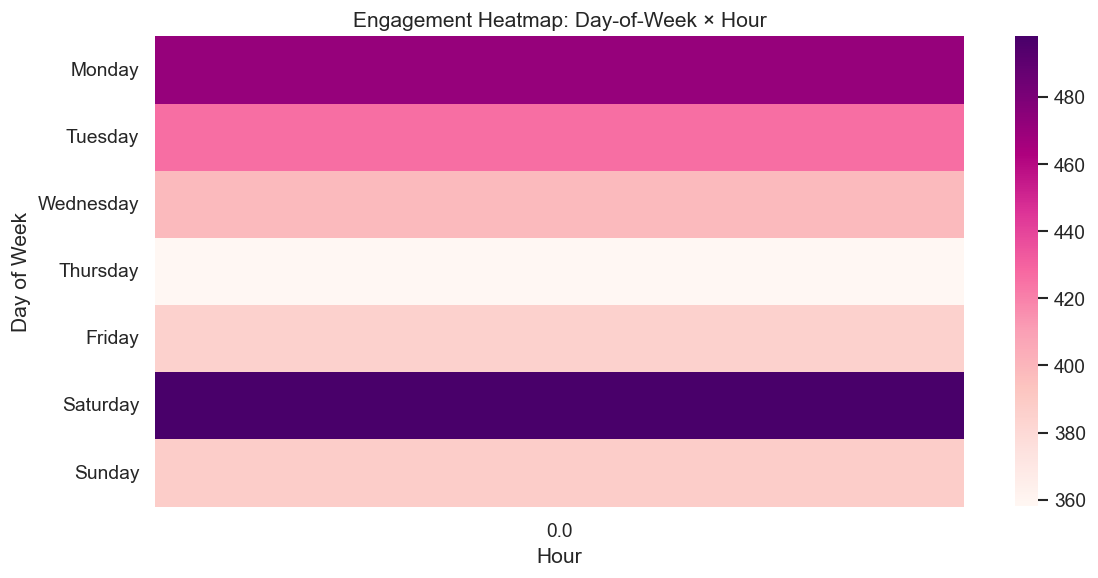

In [320]:
# Engagement Heatmap - Excluding Unknown
if 'interactiondate' in df.columns and pd.api.types.is_datetime64_any_dtype(df['interactiondate']):
    dow = df['interactiondate'].dt.day_name()
    hour = df['interactiondate'].dt.hour
    
    # Filter out Unknown day of week
    valid_rows = dow.notna()
    dow_filtered = dow[valid_rows]
    hour_filtered = hour[valid_rows]
    
    H = pd.crosstab(dow_filtered, hour_filtered)
    # Only include actual days, not Unknown
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    H = H.reindex([d for d in days_order if d in H.index], fill_value=0)
    
    print_note('Interaction Heatmap – sample totals (Unknown removed)', [f'Total cells: {H.values.size}'])
    plt.figure(figsize=(10, 5))
    sns.heatmap(H, cmap='RdPu')
    plt.title('Engagement Heatmap: Day-of-Week × Hour')
    plt.xlabel('Hour')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.savefig('eda_outputs/engagement_heatmap_day_hour.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Platform × Interaction Type (counts) - Excluding Unknown
Rows: 3, Cols: 3


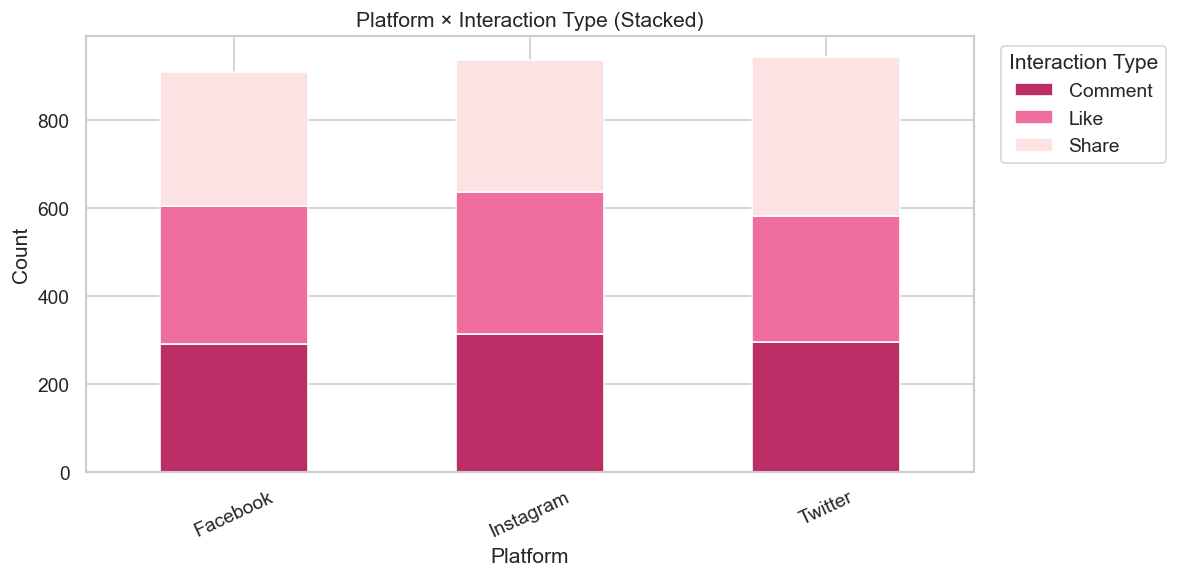

In [321]:
# Platform × Interaction Type - Excluding Unknown
if plat_col and int_col:
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered[plat_col].notna() & (df_filtered[plat_col].astype(str).str.lower() != 'unknown')]
    df_filtered = df_filtered[df_filtered[int_col].notna() & (df_filtered[int_col].astype(str).str.lower() != 'unknown')]
    
    tab = pd.crosstab(df_filtered[plat_col], df_filtered[int_col])
    print_note('Platform × Interaction Type (counts) - Excluding Unknown', [f'Rows: {tab.shape[0]}, Cols: {tab.shape[1]}'])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    tab.plot(kind='bar', stacked=True, ax=ax, color=use_palette(tab.shape[1]))
    plt.title('Platform × Interaction Type (Stacked)')
    plt.xlabel('Platform')
    plt.ylabel('Count')
    plt.xticks(rotation=25)
    plt.legend(title='Interaction Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('eda_outputs/platform_interaction_type_stacked.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

Sentiment by Platform (counts) - Excluding Unknown
Facebook: Negative=253, Neutral=365, Positive=269, Very Negative=17, Very Positive=6
Instagram: Negative=267, Neutral=352, Positive=295, Very Negative=6, Very Positive=18
Twitter: Negative=262, Neutral=384, Positive=275, Very Negative=8, Very Positive=15


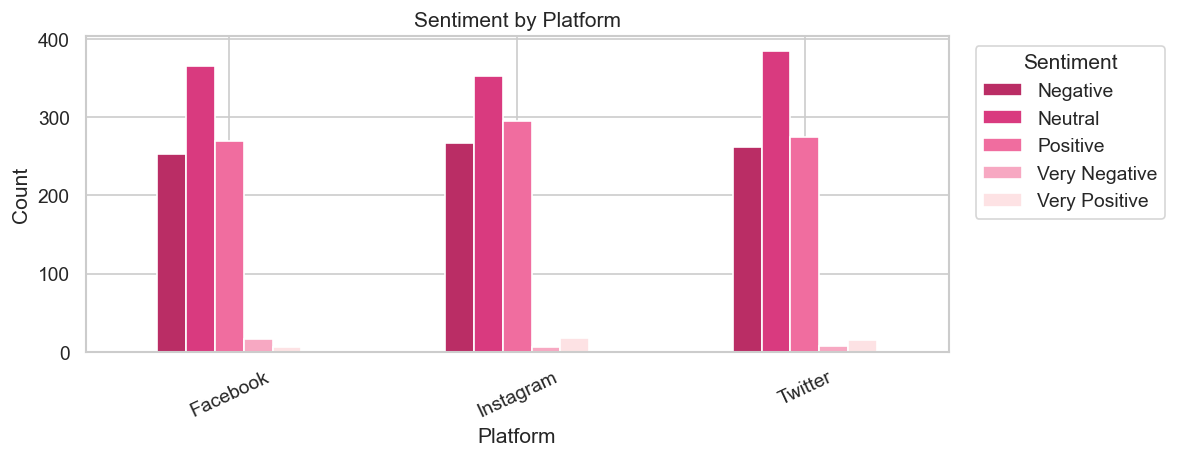

In [322]:
# Sentiment by Platform - Excluding Unknown
if plat_col and 'sentiment' in df.columns:
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered[plat_col].notna() & (df_filtered[plat_col].astype(str).str.lower() != 'unknown')]
    df_filtered = df_filtered[df_filtered['sentiment'].notna() & (df_filtered['sentiment'].astype(str).str.lower() != 'unknown')]
    
    tab = pd.crosstab(df_filtered[plat_col], df_filtered['sentiment'])
    print_note('Sentiment by Platform (counts) - Excluding Unknown',
               [f"{i}: " + ', '.join(f"{c}={tab.loc[i, c]}" for c in tab.columns) for i in tab.index])
    
    fig, ax = plt.subplots(figsize=(10, 4))
    tab.plot(kind='bar', ax=ax, color=use_palette(tab.shape[1]))
    plt.title('Sentiment by Platform')
    plt.xlabel('Platform')
    plt.ylabel('Count')
    plt.xticks(rotation=25)
    plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('eda_outputs/sentiment_by_platform.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

## L) Category Lift – High Spender Rate by Product Category

Top Product Categories by High-Spender Rate - Excluding Unknown
Clothing: 45.67%
Home & Garden: 42.74%
Health & Beauty: 40.15%
Electronics: 39.65%
Automotive: 39.56%


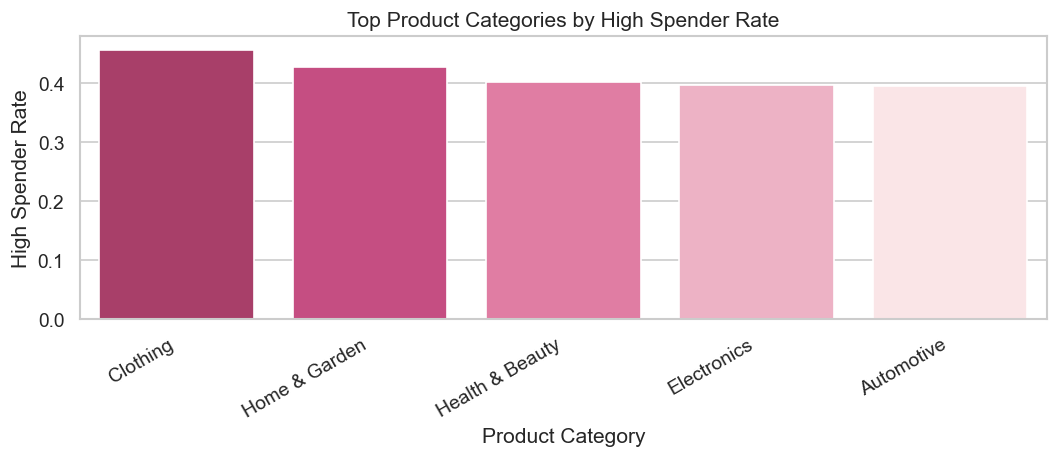

In [323]:
# Top Product Categories by High-Spender Rate - Excluding Unknown
if ('productcategory' in df.columns or 'product_category' in df.columns) and \
   ('ishighspender' in df.columns or 'high_spender' in df.columns or 'is_high_spender' in df.columns):
    cat_col = 'productcategory' if 'productcategory' in df.columns else 'product_category'
    flag_col = 'ishighspender' if 'ishighspender' in df.columns else \
               ('high_spender' if 'high_spender' in df.columns else 'is_high_spender')
    
    sub = df[[cat_col, flag_col]].copy()
    sub = sub[sub[cat_col].notna() & (sub[cat_col].astype(str).str.lower() != 'unknown')]
    sub[flag_col] = pd.to_numeric(sub[flag_col], errors='coerce').fillna(0)
    
    rate = sub.groupby(cat_col, dropna=True)[flag_col].mean().sort_values(ascending=False).head(12)
    print_note('Top Product Categories by High-Spender Rate - Excluding Unknown',
               [f"{k}: {v:.2%}" for k, v in rate.items()])
    plt.figure(figsize=(9, 4))
    sns.barplot(x=rate.index.astype(str), y=rate.values, palette=use_palette(len(rate)))
    plt.title('Top Product Categories by High Spender Rate')
    plt.xlabel('Product Category')
    plt.ylabel('High Spender Rate')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.savefig('eda_outputs/top_product_categories_by_high_spender_rate.png', dpi=300, bbox_inches='tight')  # AUTO-SAVE
    plt.show()

---
## Conclusion & Key Findings 

This EDA reflects results from the latest runs on FINAL_merged_cleaned_dataset.csv (n ≈ 3,030 rows, latest data through 2024-06-29). Results below call out concrete statistics, detected outliers, significant associations and practical recommendations.

### Statistical & Data-Quality Findings
- Dataset size and coverage: ~3,030 rows; transaction / interaction date coverage used for temporal analysis through 2024-06-29.  
- Outliers (IQR method): age (30), total_spent (22), max_transaction (14). IQR bounds were computed and used to report/optionally remove extreme values prior to some analyses.  
- ADF (monthly revenue): ADF statistic ≈ -4.362, p ≈ 0.00035 → monthly revenue series is stationary (reject unit root) at α=0.05.  
- Cumulative revenue (daily series) final value: ≈ 1,444,429.03 (cumulative over the analyzed period).

### Revenue & Temporal Patterns
- Monthly revenue shows clear seasonality and peaks: top months include 2024‑01 (~79,484) and 2023‑07 (~76,582).  
- Yearly totals (partial 2024): 2023 is the largest full-year revenue (~694,027), 2022 and 2024 are lower (2024 is partial).  
- Daily series: 730 days analyzed; 7‑day rolling average used to smooth short-term volatility.

### Spending & Correlation
- Transaction frequency vs total spend: moderate positive correlation (r ≈ 0.263) — more transactions tend to associate with higher total spend.  
- ANOVA / group comparisons: tested spending variation across demographics (age groups, gender) to surface heterogeneity (see ANOVA outputs in notebook).

### Categorical Associations (Chi-Square / Cramér's V)
- Strongest categorical associations (top significant Chi-Square pairs):  
    - gender vs age_group (p ≈ 1.9e-15)  
    - incomelevel vs age_group (p ≈ 2.6e-05)  
    - interactiontype vs sentiment (p ≈ 4.1e-05)  
    - gender vs paymentmethod (p ≈ 5.0e-04)  
- Cramér's V matrices produced for core categorical variables (gender, incomelevel, productcategory, paymentmethod, platform, interactiontype, sentiment, age_group) to quantify association strengths.

### Demographics & Engagement
- Gender split: Female 1,587 (≈52.4%), Male 1,443 (≈47.6%).  
- Age groups: largest cohort is 36–50 (996 customers).  
- Engagement heatmap (day × hour): peak interactions occur on Saturday (highest daily counts in heatmap sample).  
- Top interaction types (counts): Share (1,040), Like (1,002), Comment (988).

### Product, Payment & Platform Insights
- Top product categories by revenue (amount): Automotive, Clothing, Electronics, Home & Garden, Health & Beauty.  
- Top product categories by high‑spender rate: Clothing (~45.7%), Home & Garden (~42.7%), Health & Beauty (~40.2%).  
- Payment method volumes: Debit Card (809), PayPal (759), Credit Card (756), Bank Transfer (706).  
- Sentiment by platform: per‑platform sentiment counts available (Facebook, Instagram, Twitter shown in notebook).

### Practical Business Implications
1. Target marketing to high‑yield segments (e.g., 36–50 age band and categories with high high‑spender lift).  
2. Use payment method preferences to optimize checkout and promotions (Debit Card and PayPal are most used).  
3. Leverage Saturday / peak engagement windows for campaign timing and A/B tests.  
4. Stationarity of monthly revenue suggests differenced/seasonal models or direct forecasting approaches are viable.

### Recommended Next Steps
- Build a CLV prediction model (use num_transactions, avg_spent, engagement_score, product_category features).  
- Cohort and retention analysis (by signup month / first transaction) to monitor churn.  
- Controlled experiments (A/B) around platform-specific messaging at identified peak times.  
- Consider segmentation/clustering (RFM or behavioral features) to identify micro‑segments for high‑value targeting.

---

Data handling notes: unknown/“unknown” categorical values were excluded for category-level charts; outliers flagged via IQR (documented in notebook) and removed only where explicitly indicated. Visualizations use the prescribed pink gradient palette for consistency.